#### Import functions from other file

In [1]:
# all core functions used in this file are defined in th myFunctions file
%run myFunctionsNew.ipynb

In [38]:
%run UTM_concat.ipynb

OperationalError: 250001: Could not connect to Snowflake backend after 0 attempt(s).Aborting

OperationalError: 250001: Could not connect to Snowflake backend after 0 attempt(s).Aborting

### Read in April data

In [2]:
# csv file was filled with data from the SQL found in the appendix at the end of the file
# read data from the csv
april_df = pd.read_csv('april_df2.csv', index_col = False)

# drop the unnecessary index column
april_df.drop('Unnamed: 0', axis=1, inplace=True)

# understand our dataset now that we have pulled in the data
print(len(april_df))
print(april_df.dtypes)
april_df.head(2)

5901192
client_id                        object
month                            object
most_Watched_Channel             object
most_watched_category            object
total_tvms                      float64
user_status                      object
LINEAR_TVMS                     float64
VOD_TVMS                        float64
ADDTOWATCHLIST_FLAG             float64
FAVORITECHANNEL_FLAG            float64
SEARCHSTART_FLAG                float64
LIVEL2NAV_FLAG                  float64
VODL2NAV_FLAG                   float64
WATCHNOW_FLAG                   float64
BACKTOGUIDE_FLAG                float64
FEATURE_FLAG                    float64
tenure_days                     float64
avg_days_apart                  float64
avg_session_duration            float64
monthly_avg_session_duration    float64
frequency                       float64
monthly_frequency               float64
unique_days                     float64
day_percent                     float64
dtype: object


,client_id,month,most_Watched_Channel,most_watched_category,total_tvms,user_status,LINEAR_TVMS,VOD_TVMS,ADDTOWATCHLIST_FLAG,FAVORITECHANNEL_FLAG,...,BACKTOGUIDE_FLAG,FEATURE_FLAG,tenure_days,avg_days_apart,avg_session_duration,monthly_avg_session_duration,frequency,monthly_frequency,unique_days,day_percent
0,942d292c-21ef-5e89-99fa-abd4b90b54aa,2022-04-01,Little Baby Bum,Kids,316.92,Return User,316.92,0.00,0.00,1.00,...,1.00,1.00,521.00,3.50,63.25,21.13,43.00,15.00,9.00,0.30
1,942d2c83-7615-5022-be70-73d0cb84c935,2022-04-01,VOD,VOD,3.00,New User,0.00,3.00,0.00,0.00,...,0.00,0.00,0.00,NaN,3.00,3.00,1.00,1.00,1.00,0.03


In [3]:
# rename columns for clarity later
april_df.rename(columns = {'avg_session_duration':'overall_avg_session_duration','monthly_avg_session_duration':'avg_session_duration', 'frequency':'overall_session_frequency', 'monthly_frequency':'session_frequency'}, inplace = True)

# confirm column rename was correct and worked
april_df.columns

Index(['client_id', 'month', 'most_Watched_Channel', 'most_watched_category',
       'total_tvms', 'user_status', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'tenure_days', 'avg_days_apart',
       'overall_avg_session_duration', 'avg_session_duration',
       'overall_session_frequency', 'session_frequency', 'unique_days',
       'day_percent'],
      dtype='object')

## Transforming TVMs

In [4]:
# TVMs are very heavily skewed so we need to transform them for the analysis
# the 'transforming_columns' function is defined in the myFunctions file
april_df = transforming_columns(april_df,['total_tvms'])

In [5]:
# lets remove any users above 43,200 since it should be technically impossible to have that many TVMs 
    # and there are only 5 of theses users
# lets remove any users with a TVM value of 0 since we get a negative infinity value for those users when we do a log transform 
    # and there are onl 154 users with a 0 TVM value out of the 5.9 million users in the dataframe
april_df1 = april_df[(april_df['total_tvms'] != 0) & (april_df['total_tvms'] < 43200)].copy()

# confirm the new df looks good
print(len(april_df1))
print(april_df1.columns)

5901034
Index(['client_id', 'month', 'most_Watched_Channel', 'most_watched_category',
       'total_tvms', 'user_status', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'tenure_days', 'avg_days_apart',
       'overall_avg_session_duration', 'avg_session_duration',
       'overall_session_frequency', 'session_frequency', 'unique_days',
       'day_percent', 'log_transform_total_tvms'],
      dtype='object')


# Multidimensional Clustering

### Raw segmentation on the following variables:
- Session Frequency 
- Daily Frequency
- VOD TVMs
- ASD
- Total TVMs

In [6]:
# Creating a dataframe with only the necessary data points for clustering
sesfreq_Day_VOD_ASD_TVM_df = april_df1[['client_id','session_frequency','unique_days','VOD_TVMS','avg_session_duration','log_transform_total_tvms','total_tvms']]

# confirm it looks good
sesfreq_Day_VOD_ASD_TVM_df.head(1)

,client_id,session_frequency,unique_days,VOD_TVMS,avg_session_duration,log_transform_total_tvms,total_tvms
0,942d292c-21ef-5e89-99fa-abd4b90b54aa,15.00,9.00,0.00,21.13,5.76,316.92


In [7]:
# Scaling the data to ensure proper weighting for the clustering
# the 'scale_' function is defined in the myFunctions file
scaled_data1 = scale_(sesfreq_Day_VOD_ASD_TVM_df[['log_transform_total_tvms','avg_session_duration','session_frequency','VOD_TVMS','unique_days']])

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


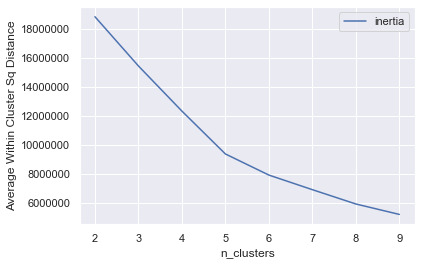

In [8]:
# elbow plot on a range of cluster sizes to see where diminishing returns begin
# 'elbow_plot' function defined in myFunctions
elbow_plot(min_cluster = 2,max_cluster = 10,scaled_data = scaled_data1)

In [11]:
# now that we see that diminishing returns begins around 5 and 6 lets run a clustering on 5 and 6
# 'clustering' function is defined in myFunctions file
sesfreq_Day_VOD_ASD_TVM_df = clustering(sesfreq_Day_VOD_ASD_TVM_df,cluster_amounts = [5,6],scaled_data = scaled_data1)

In [12]:
# lets look at information around the clusters
# 'description_ver2' function is defined in myFunctions file
describe5 = description_ver2(sesfreq_Day_VOD_ASD_TVM_df,column = ['total_tvms','session_frequency','avg_session_duration','VOD_TVMS','unique_days'],cluster_value = 5)

# lets just look at the following columns from the describe as they are the 'most' important
describe5[['count', 'min','mean','max','index','percent', 'variable']]

,count,min,mean,max,index,percent,variable
kmeans_5_color,,,,,,,
powderblue,838.00,0.00,281.63,"40,288.75",2.81,0.01,VOD_TVMS
powderblue,838.00,"8,591.14","17,021.79","43,171.23",179.25,0.01,avg_session_duration
powderblue,838.00,1.00,2.29,5.00,0.29,0.01,session_frequency
powderblue,838.00,"8,625.10","32,757.27","43,171.23",30.06,0.01,total_tvms
powderblue,838.00,1.00,24.18,30.00,4.48,0.01,unique_days
purple,"32,161.00","2,245.22","4,941.24","41,157.52",49.38,0.55,VOD_TVMS
purple,"32,161.00",12.36,279.63,"10,422.25",2.94,0.55,avg_session_duration
purple,"32,161.00",1.00,37.40,694.00,4.77,0.55,session_frequency
purple,"32,161.00","2,554.98","8,882.12","42,311.32",8.15,0.55,total_tvms


In [13]:
# this is the same as above just looking at the 6 cluster rather than 5 so that we can compare and determine which is better
describe6 = description_ver2(sesfreq_Day_VOD_ASD_TVM_df,column = ['total_tvms','session_frequency','avg_session_duration','VOD_TVMS','unique_days'],cluster_value = 6)

# again only looking at the 'most' important fields from the describe
describe6[['count', 'min','mean','max','index','percent', 'variable']]

,count,min,mean,max,index,percent,variable
kmeans_6_color,,,,,,,
purple,838.00,0.00,281.63,"40,288.75",2.81,0.01,VOD_TVMS
purple,838.00,"8,591.14","17,021.79","43,171.23",179.25,0.01,avg_session_duration
purple,838.00,1.00,2.29,5.00,0.29,0.01,session_frequency
purple,838.00,"8,625.10","32,757.27","43,171.23",30.06,0.01,total_tvms
purple,838.00,1.00,24.18,30.00,4.48,0.01,unique_days
powderblue,"29,715.00","2,245.22","5,129.24","41,157.52",51.26,0.50,VOD_TVMS
powderblue,"29,715.00",21.80,283.83,"10,422.25",2.99,0.50,avg_session_duration
powderblue,"29,715.00",1.00,37.73,528.00,4.81,0.50,session_frequency
powderblue,"29,715.00","2,646.38","9,084.01","42,311.32",8.34,0.50,total_tvms


### PCA on the same 5 variables:
- Session Frequency 
- Daily Frequency
- VOD TVMs
- ASD
- Total TVMs

In [15]:
# repeating the scaling of the data, treating this like its own section with each step
scaled_data1 = scale_(sesfreq_Day_VOD_ASD_TVM_df[['log_transform_total_tvms','avg_session_duration','session_frequency','VOD_TVMS','unique_days']])

In [16]:
# start by defining pca without a set number of components since we dont know the ideal number of components yet
pca = PCA()

# fit the scaled data to the pca to get the variance ratio to determine ideal number of clusters
pca.fit(scaled_data1)

# view the actual variance ratio values before we plot them below
pca.explained_variance_ratio_

array([0.51942974, 0.19745866, 0.17905926, 0.08360361, 0.02044874])

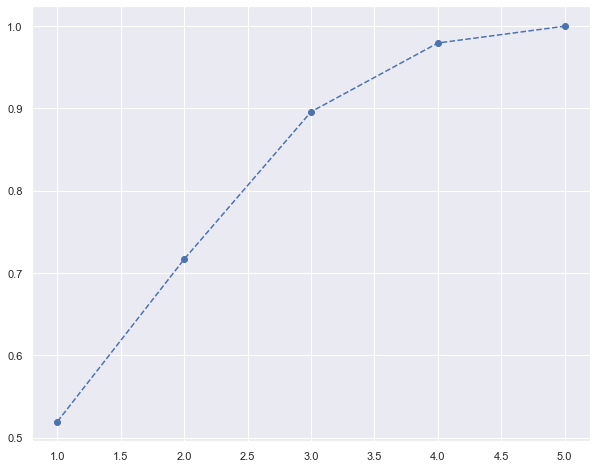

In [17]:
# plot the variance ratios with cumulative sum to see 
   # how many components we need to use to achieve the desired percentage of variance
plt.figure(figsize = (10,8))
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')

In [18]:
# 3 components gives us nearly 90% variance so lets redo the PCA with 3 components
pca = PCA(n_components = 3)

# lets refit the scaled data with 3 components set
pca.fit(scaled_data1)

PCA(n_components=3)

In [19]:
# Lets look at the component composition as well in a nice dataframe format
component_comp_df = pd.DataFrame(abs(pca.components_),columns = ['log_transform_total_tvms','avg_session_duration','session_frequency','VOD_TVMS','unique_days'])

# output it
component_comp_df

,log_transform_total_tvms,avg_session_duration,session_frequency,VOD_TVMS,unique_days
0,0.51,0.20,0.55,0.25,0.58
1,0.11,0.91,0.30,0.15,0.19
2,0.12,0.21,0.11,0.96,0.13


In [20]:
# next we gather our PCA scores 
scores_pca = pca.transform(scaled_data1)

In [21]:
pd.DataFrame(scores_pca)

,0,1,2
0,0.67,-0.47,-0.31
1,-1.36,-0.22,0.15
2,-0.27,0.80,0.20
3,-0.77,0.07,-0.02
4,-0.16,0.08,0.06
...,...,...,...
5901029,3.40,-0.58,-0.97
5901030,5.98,-1.83,-0.76
5901031,-1.13,-0.24,0.09
5901032,0.76,0.34,-0.44


In [24]:
# now we concat the original dataframe that has the 5 variables we used as well as the descriptor 
    # variables with the PCA components otherwise defined as the PCA scores
full_df_segm_pca_kmeans = pd.concat([april_df1.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)

# we can rename those PCA scores to their proper names of component 1 - 3
full_df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1','Component 2','Component 3']

# lets check the dataframe to make sure everything we did looks good
full_df_segm_pca_kmeans.head(1)
print(full_df_segm_pca_kmeans.columns)

# we will use this dataframe later for adding in the clustering labels

Index(['client_id', 'month', 'most_Watched_Channel', 'most_watched_category',
       'total_tvms', 'user_status', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'tenure_days', 'avg_days_apart',
       'overall_avg_session_duration', 'avg_session_duration',
       'overall_session_frequency', 'session_frequency', 'unique_days',
       'day_percent', 'log_transform_total_tvms', 'Component 1', 'Component 2',
       'Component 3'],
      dtype='object')


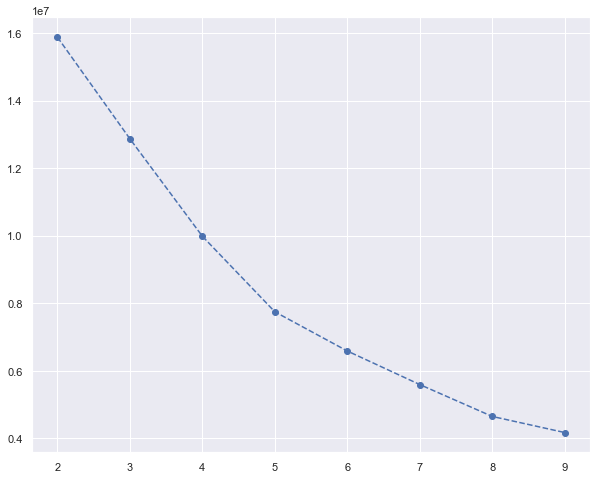

In [25]:
# now we are going to find the ideal number of clusters for the k-means clustering off of the pca scores 
# by running the clustering on a range of values to generate an elbow plot to see where we have diminishing returns
temp = []
for i in range(2,10):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
    kmeans_pca.fit(scores_pca)
    temp.append(kmeans_pca.inertia_)

# elbow plot generation
plt.figure(figsize = (10,8))
plt.plot(range(2,10), temp, marker = 'o', linestyle = '--')
plt.show()

### 5 clustering

In [ ]:
# as we see in the elbow plot above the returns begin to diminish at 5 and 6 so we run the clustering on 5 for comparison to 6
kmeans_pca5 = KMeans(n_clusters = 5, init = 'k-means++', random_state = 10)

# now we fit the pca scores to the clustering now that we defined it above
kmeans_pca5.fit(scores_pca)

# now we can add in the clustering values to the full dataframe with our variables and descriptors
full_df_segm_pca_kmeans['Segment K-Means PCA 5'] = kmeans_pca5.labels_

# lets confirm the dataframe is looking good with all our variables, all our descriptors, our  3 components and 5 and 6 clusters
full_df_segm_pca_kmeans.columns

In [ ]:
# Next describe the clusters to get an understanding of what the users in each look like
# 'description_PCA' function is defined in the myFunctions file
PCA_describe_5 = description_PCA(full_df_segm_pca_kmeans,column = ['total_tvms','session_frequency','avg_session_duration','VOD_TVMS','unique_days','tenure_days'],cluster_value = 5)

# the desciption has more than just the columns below but to remove noise I chose those 7 fields bec I think theyre most important
PCA_describe_5[['count', 'min','mean','max','index','percent', 'variable']]

In [ ]:
# 3D plots with the 3 components on different axes to help visulize
_3d_plots(full_df_segm_pca_kmeans,cluster_value = 5)

In [ ]:
# grab all the individual clusters flag user percent usage
temp_array = all_flag_info(full_df_segm_pca_kmeans,cluster_value_ = 5)

# put it into a nice dataframe for viewing
Flag_describe = pd.DataFrame(temp_array,columns = ['Cluster','ADDTOWATCHLIST_FLAG','FAVORITECHANNEL_FLAG','SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG'])

# output the describe
Flag_describe

In [ ]:
# most watched channel by percent of users that have that channel as their most watched
most_Watched_or_user_status(full_df_segm_pca_kmeans,chan_or_cat = 'most_Watched_Channel',cluster_value = 5,top_amount = 3)

In [ ]:
# mostwatched category by percent of users that have that category as their most watched
most_Watched_or_user_status(full_df_segm_pca_kmeans,chan_or_cat = 'most_watched_category',cluster_value = 5,top_amount = 3)

In [ ]:
most_Watched_or_user_status(full_df_segm_pca_kmeans,chan_or_cat = 'user_status',cluster_value = 5,top_amount = 2)

### 6 clusters

In [26]:
# next do the clustering on 6 clusters so that we can compare to the 5 clusters
kmeans_pca6 = KMeans(n_clusters = 6, init = 'k-means++', random_state = 10)

# defined on line above and now fit the pca scores to the clustering for 6 clusters
kmeans_pca6.fit(scores_pca)

# now we can add in the clustering values to the full dataframe with our variables and descriptors
full_df_segm_pca_kmeans['Segment K-Means PCA 6'] = kmeans_pca6.labels_

# lets confirm the dataframe is looking good with all our variables, all our descriptors, our  3 components and 5 and 6 clusters
full_df_segm_pca_kmeans.columns

Index(['client_id', 'month', 'most_Watched_Channel', 'most_watched_category',
       'total_tvms', 'user_status', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'tenure_days', 'avg_days_apart',
       'overall_avg_session_duration', 'avg_session_duration',
       'overall_session_frequency', 'session_frequency', 'unique_days',
       'day_percent', 'log_transform_total_tvms', 'Component 1', 'Component 2',
       'Component 3', 'Segment K-Means PCA 6'],
      dtype='object')

In [27]:
bins = [-np.inf, 0, 30, 90, 180, 365, np.inf]
full_df_segm_pca_kmeans['tenures'] = pd.cut(full_df_segm_pca_kmeans['tenure_days'], bins)
full_df_segm_pca_kmeans.groupby('Segment K-Means PCA 6')['client_id'].count()

Segment K-Means PCA 6
0    2468402
1     392531
2     782115
3    2227072
4        867
5      30047
Name: client_id, dtype: int64

In [28]:
temp_tenure = full_df_segm_pca_kmeans[['client_id', 'tenures', 'Segment K-Means PCA 6']].groupby(
    ['Segment K-Means PCA 6', 'tenures']).count()

temp_tenure = temp_tenure.reset_index().rename(columns = {'client_id' : 'count', 'Segment K-Means PCA 6':'Segment'})
temp_tenureTTL = full_df_segm_pca_kmeans[['client_id', 'tenures']].groupby(
    ['tenures']).count()

temp_tenure = temp_tenure.merge(temp_tenureTTL, on='tenures', how='left').rename(columns = {'client_id': 'totals'})

# temp_tenure.assign(tenure_pct = temp_tenure.count/temp_tenure.totals)

temp_tenure.to_csv('tenure.csv')


In [29]:
# next describe the clusters when using 6 clusters to understand the users in each
PCA_describe_6 = description_PCA(full_df_segm_pca_kmeans,column = ['total_tvms','session_frequency','avg_session_duration','VOD_TVMS','unique_days','tenure_days'],cluster_value = 6)

# only printing these 7 columns as i feel they are the most vital to look at
PCA_describe_6[['count', 'min','mean','max','index','percent', 'variable']]

,count,min,mean,max,index,percent,variable
Segment K-Means PCA 6,,,,,,,
4,867.00,0.00,275.94,"40,288.75",2.76,0.01,VOD_TVMS
4,867.00,"8,407.68","16,736.41","43,171.23",176.24,0.01,avg_session_duration
4,867.00,1.00,2.34,5.00,0.30,0.01,session_frequency
4,867.00,0.00,704.46,"2,267.00",1.57,0.01,tenure_days
4,867.00,"8,426.18","32,679.04","43,171.23",29.99,0.01,total_tvms
4,867.00,1.00,24.13,30.00,4.47,0.01,unique_days
5,"30,047.00","2,414.38","5,102.80","41,157.52",50.99,0.51,VOD_TVMS
5,"30,047.00",21.80,281.84,"10,422.25",2.97,0.51,avg_session_duration
5,"30,047.00",1.00,37.66,528.00,4.80,0.51,session_frequency


In [30]:
PCA_describe_6.loc[PCA_describe_6['variable']== 'tenure_days', ['mean', 'variable']]

,mean,variable
Segment K-Means PCA 6,,
4,704.46,tenure_days
5,449.27,tenure_days
1,600.20,tenure_days
2,544.85,tenure_days
3,385.45,tenure_days
0,450.11,tenure_days


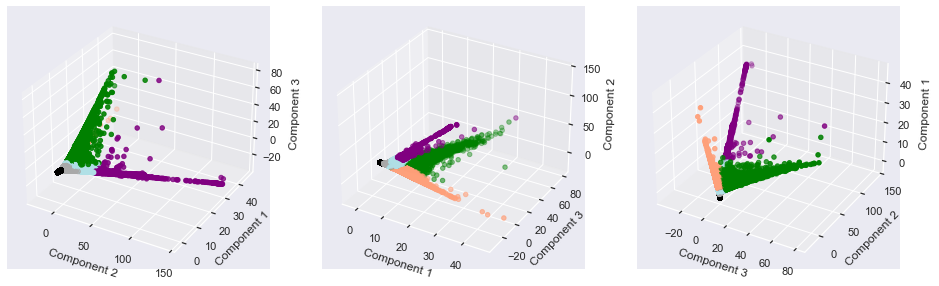

In [31]:
# 3D plots with the 3 components on different axes to help visulize
_3d_plots(full_df_segm_pca_kmeans,cluster_value = 6)

In [32]:
# grab all the individual clusters flag user percent usage
temp_array = all_flag_info(full_df_segm_pca_kmeans,cluster_value_ = 6)

# put it into a nice dataframe for viewing
Flag_describe = pd.DataFrame(temp_array,columns = ['Cluster','ADDTOWATCHLIST_FLAG','FAVORITECHANNEL_FLAG','SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG'])

# output the describe
Flag_describe#.to_csv('user_percent.csv')

,Cluster,ADDTOWATCHLIST_FLAG,FAVORITECHANNEL_FLAG,SEARCHSTART_FLAG,LIVEL2NAV_FLAG,VODL2NAV_FLAG,WATCHNOW_FLAG,BACKTOGUIDE_FLAG,FEATURE_FLAG
0,0,3.53,5.17,14.72,46.65,23.39,20.75,39.07,69.88
1,1,9.97,21.11,26.65,82.87,40.99,28.75,69.80,92.47
2,2,7.38,12.98,22.49,73.46,36.23,27.60,60.32,87.89
3,3,1.95,2.69,12.22,31.32,15.15,7.40,26.98,55.47
4,4,1.04,6.92,5.31,33.56,6.46,5.07,24.91,42.10
5,5,29.20,21.66,56.22,69.29,88.39,88.47,65.84,98.41


In [33]:
# top_seg = pd.DataFrame(full_df_segm_pca_kmeans.groupby(['most_Watched_Channel'])['client_id'].nunique().sort_values(ascending=False))
# top_seg = top10_seg.assign(mix_pct = top10[['client_id']]/full_df_segm_pca_kmeans['client_id'].nunique())
# top_seg.to_csv('TopChannel1.csv')


seg_cat = full_df_segm_pca_kmeans.groupby(['Segment K-Means PCA 6', 'most_watched_category'])['client_id'].count().reset_index()
top_cat = full_df_segm_pca_kmeans.groupby(['most_watched_category'])['client_id'].count().reset_index()

In [34]:
print(seg_cat.columns)
print(top_cat.columns)

Index(['Segment K-Means PCA 6', 'most_watched_category', 'client_id'], dtype='object')
Index(['most_watched_category', 'client_id'], dtype='object')


In [35]:
Categories = top_cat.merge(seg_cat, on= 'most_watched_category', how = 'left').rename(columns = {'client_id_x': 'Cat_TTL', 
                                                                                       'client_id_y' : 'Seg_TTL'})

Categories

,most_watched_category,Cat_TTL,Segment K-Means PCA 6,Seg_TTL
0,Classic TV,543069,0,221723
1,Classic TV,543069,1,84027
2,Classic TV,543069,2,122433
3,Classic TV,543069,3,112556
4,Classic TV,543069,4,185
...,...,...,...,...
94,VOD,1240791,1,4846
95,VOD,1240791,2,90087
96,VOD,1240791,3,419697
97,VOD,1240791,4,5


In [36]:
Totals = pd.DataFrame({'seg_ttl' :full_df_segm_pca_kmeans.groupby('Segment K-Means PCA 6')['client_id'].count(),
              'All_ttl' :  full_df_segm_pca_kmeans['client_id'].count()})



In [37]:
CompareCat = Categories.merge(Totals, on= 'Segment K-Means PCA 6', how='left')
CompareCat = CompareCat.assign(seg_pct = CompareCat['Seg_TTL']/CompareCat['seg_ttl'], all_pct =
                 CompareCat['Cat_TTL']/CompareCat['All_ttl'], index = 
                               (CompareCat['Seg_TTL']/CompareCat['seg_ttl'])/(CompareCat['Cat_TTL']/CompareCat['All_ttl'] ))

CompareCat

,most_watched_category,Cat_TTL,Segment K-Means PCA 6,Seg_TTL,seg_ttl,All_ttl,seg_pct,all_pct,index
0,Classic TV,543069,0,221723,2468402,5901034,0.09,0.09,0.98
1,Classic TV,543069,1,84027,392531,5901034,0.21,0.09,2.33
2,Classic TV,543069,2,122433,782115,5901034,0.16,0.09,1.70
3,Classic TV,543069,3,112556,2227072,5901034,0.05,0.09,0.55
4,Classic TV,543069,4,185,867,5901034,0.21,0.09,2.32
...,...,...,...,...,...,...,...,...,...
94,VOD,1240791,1,4846,392531,5901034,0.01,0.21,0.06
95,VOD,1240791,2,90087,782115,5901034,0.12,0.21,0.55
96,VOD,1240791,3,419697,2227072,5901034,0.19,0.21,0.90
97,VOD,1240791,4,5,867,5901034,0.01,0.21,0.03


In [ ]:
CompareCat


In [ ]:
Categories.head()

In [ ]:
full_df_segm_pca_kmeans.groupby('Segment K-Means PCA 6')['client_id'].count()

In [ ]:
compare_cat = all_chan.merge(top_cat, on='most_watched_category', how='left').rename(columns={'client_id_x': 'segment', 'client_id_y': 'All'})

compare_cat.assign(seg_cnt = )

In [ ]:
# most_Watched_or_user_status(full_df_segm_pca_kmeans,chan_or_cat = 'most_Watched_Channel',cluster_value = 6,top_amount = 3)

In [ ]:
# most_Watched_or_user_status(full_df_segm_pca_kmeans,chan_or_cat = 'most_watched_category',cluster_value = 6,top_amount = 3)

In [ ]:
# most_Watched_or_user_status(full_df_segm_pca_kmeans,chan_or_cat = 'user_status',cluster_value = 6,top_amount = 2)

In [ ]:
import seaborn as sns


In [ ]:
metric_df = full_df_segm_pca_kmeans[['total_tvms', 'avg_session_duration', 'session_frequency', 'unique_days', 'Segment K-Means PCA 6']]

In [ ]:
sns.pairplot(metric_df)

In [ ]:
# sns.pairplot(metric_df, hue='Segment K-Means PCA 6')

In [ ]:
full_df_segm_pca_kmeans.columns

In [ ]:
temp5  = full_df_segm_pca_kmeans[['total_tvms', 'log_transform_total_tvms']]

In [ ]:
sns.pairplot(temp5)

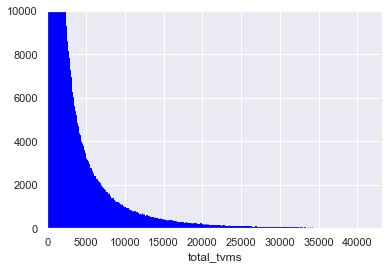

In [213]:
plt.hist(april_df1['total_tvms'],bins = 1000, ec="blue");
plt.ylim(0,10000);
plt.xlim(0,43200);
plt.xlabel('total_tvms');
plt.ticklabel_format(style='plain');
plt.show();

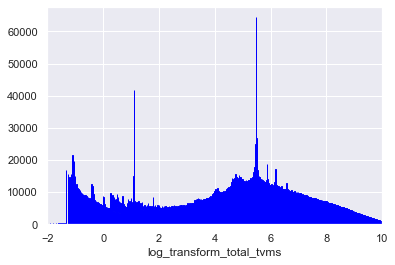

In [208]:
plt.hist(april_df1['log_transform_total_tvms'],bins = 1000, ec="blue");
# plt.ylim(0,43200);
plt.xlim(-2, 10);
plt.xlabel('log_transform_total_tvms');
plt.ticklabel_format(style='plain');
plt.show();

### APPENDIX

#### SQL

In [ ]:
# USER_SEGMENTATIONS_UPDATED creation SQL

# USE DATABASE SANDBOX;
# USE SCHEMA ANALYSIS_PRODUCT;
# CREATE OR REPLACE TRANSIENT TABLE USER_SEGMENTATIONS_UPDATED (
#     client_id varchar(255) default NULL,
#     month date default NULL,
#     tenure_days number(10,5) default NULL,
#     user_status varchar(20) default NULL,
#     most_watched_channel varchar(255) default NULL,
#     most_watched_category varchar(255) default NULL,
#     total_tvms number(10,5) default NULL,
#     linear_tvms number(10,5) default NULL,
#     vod_tvms number(10,5) default NULL,
#     addtowatchlist_flag number(10,5) default NULL,
#     favoritechannel_flag number(10,5) default NULL,
#     searchstart_flag number(10,5) default NULL,
#     livel2nav_flag number(10,5) default NULL,
#     vodl2nav_flag number(10,5) default NULL,
#     watchnow_flag number(10,5) default NULL,
#     backtoguide_flag number(10,5) default NULL,
#     feature_flag number(10,5) default NULL
# );

# INSERT INTO SANDBOX.ANALYSIS_PRODUCT.USER_SEGMENTATIONS_UPDATED(client_id, month, tenure_days, user_status,most_watched_channel,most_watched_category,total_tvms,linear_tvms,vod_tvms,                                                  addtowatchlist_flag,favoritechannel_flag,searchstart_flag,livel2nav_flag,vodl2nav_flag,watchnow_flag,backtoguide_flag,feature_flag)
# WITH client_base AS (
#     select distinct agg.client_id ,
#            date_trunc('month',VIDEO_SEGMENT_BEGIN_UTC) as month,
#            sum(total_viewing_minutes) as month_TVMs,
#            sum(case when channel_id not in ('vod') then total_viewing_minutes else 0 end) as month_linear_TVMs,
#            sum(case when channel_id in ('vod') then total_viewing_minutes else 0 end) as month_vod_TVMs
#     from ODIN_PRD.RPT.ALL_HOURLY_TVS_AGG agg
#     where 1=1
#       and GEO_ALIGNED_FLAG = True
#       and EP_SOURCES_ALIGNED_FLAG = True
#       and TIMELINE_ALIGNED_FLAG = True
#       and country = 'US'
#       --and date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-04-01' and '2022-04-30'
#       and date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-01-01' and '2022-05-31'
#       and lower(agg.app_name) = 'roku'
#     group by 1,2
# ),

# tenure_cohort_prep as (
#     select distinct agg.client_id ,
#            date_trunc('month',VIDEO_SEGMENT_BEGIN_UTC) as month,
#             max(date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC)) as max_day
#     from ODIN_PRD.RPT.ALL_HOURLY_TVS_AGG agg
#     where 1=1
#         and GEO_ALIGNED_FLAG = True
#         and EP_SOURCES_ALIGNED_FLAG = True
#         and TIMELINE_ALIGNED_FLAG = True
#         and country = 'US'
#         --and date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-04-01' and '2022-04-30'
#         and date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-01-01' and '2022-05-31'
#         and lower(agg.app_name) = 'roku'
#     group by 1,2
# ),

# tenure_cohort as
# (
#   select distinct acfs.client_id,
#          tcp.month,
#          datediff(day,date_trunc('day',client_first_Seen_utc), max_day) as tenure_days,
#          case when date_trunc('month',client_first_Seen_utc) = date_trunc('month',max_day) then 'New User' else 'Return User' end as user_status
#   from ODIN_PRD.RPT.ALL_CLIENT_FIRST_SEEN acfs
#   join tenure_cohort_prep tcp on tcp.client_id = acfs.client_id
# ),

# most_watched_base as
# (
#   SELECT distinct
#       agg.client_id,
#       ch.channel_name,
#       case when ch.channel_id = 'vod' then 'VOD' else ch.category_name end as category_name,
#       date_trunc('month',VIDEO_SEGMENT_BEGIN_UTC) as month,
#       sum(total_viewing_minutes) over (partition by agg.client_id,ch.channel_name,month) as channel_TVMs,
#       sum(total_viewing_minutes) over (partition by agg.client_id,category_name,month) as category_TVMs
#   FROM ODIN_PRD.RPT.ALL_HOURLY_TVS_AGG    agg
#   join ODIN_PRD.DW_ODIN.CMS_CHANNEL_DIM   ch on ch.CHANNEL_ID = agg.CHANNEL_ID
#   WHERE 1=1
#     and GEO_ALIGNED_FLAG = True
#     and EP_SOURCES_ALIGNED_FLAG = True
#     and TIMELINE_ALIGNED_FLAG = True
#     AND country = 'US'
#     --AND date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) = '2022-01-01'
#     --AND date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-04-01' and '2022-04-30'
#     AND date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-01-01' and '2022-05-31'
#     AND lower(agg.app_name) = 'roku'
# ),

# most_watched as
# (
#   select distinct
#       client_id,
#       channel_name,
#       category_name,
#       month,
#     -- changed the following two lines to row_number instead of dense_rank since dense_rank was creating duplicates
#       row_number() over (partition by client_id,month order by category_TVMs DESC) as category_rank,
#       row_number() over (partition by client_id,month order by channel_TVMs DESC) as channel_rank
#   from most_watched_base
# ),

# top_category as
# (
#     select distinct
#            client_id
#           ,category_name
#           ,month
#     from most_watched
#     where category_rank = 1
#     order by 1
# ),

# top_channel as
# (
#     select distinct
#            client_id
#           ,channel_name
#           ,month
#     from most_watched
#     where channel_rank = 1
#     order by 1
# ),

#     features as
# (
#     select distinct
#            client_id
#           , date_trunc('month',time_stamp) as month
#     -- i think we could have just taken the max here rather than summing and having another case statement
#           , case when (sum(case when event_name in ('userAction') and screen_element_name in ('addtowatchlist') then 1 else 0 end)) > 0 then 1 else 0 end as addtowatchlist_flag
#           , case when (sum(case when event_name in ('userAction') and screen_element_name in ('favoritechannel') then 1 else 0 end)) > 0 then 1 else 0 end as favoritechannel_flag
#           , case when (sum(case when event_name in ('userAction') and screen_element_name in ('search') then 1 else 0 end)) > 0 then 1 else 0 end as searchstart_flag
#           , case when (sum(case when event_name in ('userAction') and screen_element_name in ('livel2nav') then 1 else 0 end)) > 0 then 1 else 0 end as livel2nav_flag
#           , case when (sum(case when event_name in ('userAction') and screen_element_name in ('vodl2nav') then 1 else 0 end)) > 0 then 1 else 0 end as vodl2nav_flag
#           , case when (sum(case when event_name in ('userAction') and screen_element_name in ('watchnow') then 1 else 0 end)) > 0 then 1 else 0 end as watchnow_flag
#           , case when (sum(case when event_name in ('userAction') and screen_element_name in ('backtoguide') then 1 else 0 end)) > 0 then 1 else 0 end as backtoguide_flag
#           , case when (sum(case when event_name in ('userAction') and screen_element_name in ('addtowatchlist','favoritechannel','search','livel2nav','vodl2nav','watchnow','backtoguide') then 1 else 0 end)) > 0 then 1 else 0 end as feature_flag
#    from "ODIN_PRD"."RPT"."BI_USER_ENGAGEMENT360"
#     where country = 'US'
#     --AND date_trunc('day',time_stamp) between '2022-04-01' and '2022-04-30'
#     AND date_trunc('day',time_stamp) between '2022-01-01' and '2022-05-31'
#     AND lower(app_name) = 'roku'
#     group by 1,2
#     order by 1
# )
# select distinct
#         cb.client_id,
#         cb.month,
#         tenure_days,
#         user_status,
#         tch.channel_name,
#         tca.category_name,
#         cb.month_TVMs,
#         cb.month_linear_TVMs,
#         cb.month_vod_TVMs,
#         f.addtowatchlist_flag,
#         f.favoritechannel_flag,
#         f.searchstart_flag,
#         f.livel2nav_flag,
#         f.vodl2nav_flag,
#         f.watchnow_flag,
#         f.backtoguide_flag,
#         f.feature_flag
# from client_base cb
# join tenure_cohort  tc  on  tc.client_id = cb.client_id and  tc.month = cb.month
# join top_channel    tch on tch.client_id = cb.client_id and tch.month = cb.month
# join top_category   tca on tca.client_id = cb.client_id and tca.month = cb.month
# join features       f on f.client_id = cb.client_id and f.month = cb.month
#     ;

In [ ]:
# VIEWERSHIP_PATTERNS creation SQL

# USE DATABASE SANDBOX;
# USE SCHEMA ANALYSIS_PRODUCT;
# CREATE OR REPLACE TRANSIENT TABLE VIEWERSHIP_PATTERNS (
#     client_id varchar(255) default NULL, 
#     month DATE default NULL,
#     avg_days_apart number(10,2) default NULL,
#     avg_session_duration number (10,2) default NULL,
#     monthly_avg_session_duration number(10,2) default NULL,
#     frequency number(10,2) default NULL,
#     monthly_frequency number(10,2) default NULL,
#     unique_days number (10,2) default NULL,
#     day_percent number (10,2) default NULL
# )
# ;

# INSERT INTO SANDBOX.ANALYSIS_PRODUCT.VIEWERSHIP_PATTERNS(client_id, month, avg_days_apart, avg_session_duration, monthly_avg_session_duration, frequency, monthly_frequency, unique_days, day_percent)
# with days_between_calc_1 as (
# select distinct client_id
# , date_trunc('day', video_segment_begin_utc) as date_time
# FROM "ODIN_PRD"."RPT"."ALL_HOURLY_TVS_AGG"
# where date_trunc('day', video_segment_begin_utc) between '2022-01-01' and '2022-05-31'
# and timeline_aligned_flag = TRUE
# and geo_aligned_flag = TRUE
# and ep_sources_aligned_flag = TRUE 
# and lower(app_name) in ('roku')
# and lower(country) in ('us')
# ),

# days_between_calc_2 as (
# SELECT distinct client_id, date_time, LAG(date_time) 
#   OVER (PARTITION BY client_id ORDER BY date_time asc) as priordate
#   from days_between_calc_1
# ),

# days_between_calc_3 as (
# select distinct client_id
# , AVG(DATEDIFF(DAY, priordate, date_time)) as avg_lag
# from days_between_calc_2
# group by 1),

# days_visited_calc as (
# select distinct client_id
# , date_trunc('month', date_time) as month
# , count(distinct(date_time)) as unique_days
# , datediff('day', month, last_day(date_time, 'month')+1) as total_days
# , unique_days / total_days as day_percent
# from days_between_calc_1
# group by 1,2,4),

# session_month_table as (
# select
# distinct client_id
# , date_trunc('month', video_segment_begin_utc) as month 
# , session_id
# , sum(total_viewing_minutes) as duration 
# from "ODIN_PRD"."RPT"."ALL_HOURLY_TVS_AGG"
# where date_trunc('day', video_segment_begin_utc) between '2022-01-01' and '2022-05-31'
# and timeline_aligned_flag = TRUE
# and geo_aligned_flag = TRUE
# and ep_sources_aligned_flag = TRUE 
# and lower(app_name) in ('roku')
# and lower(country) in ('us')
# group by 1,2,3
# ),

# session_month_table_calc as (
# select
# distinct client_id
# , month
# , count(distinct(session_id)) as monthly_frequency
# , avg(duration) as monthly_avg_session_duration
# from session_month_table
# group by 1,2
# ),

# session_agg_table as (
# select
# distinct client_id
# , session_id
# , sum(total_viewing_minutes) as duration 
# from "ODIN_PRD"."RPT"."ALL_HOURLY_TVS_AGG"
# where date_trunc('day', video_segment_begin_utc) between '2022-01-01' and '2022-05-31'
# and timeline_aligned_flag = TRUE
# and geo_aligned_flag = TRUE
# and ep_sources_aligned_flag = TRUE 
# and lower(app_name) in ('roku')
# and lower(country) in ('us')
# group by 1,2
# ),

# session_agg_table_calc as (
# select
# distinct client_id
# , count(distinct(session_id)) as frequency
# , avg(duration) as avg_session_duration
# from session_agg_table
# group by 1
# )

# select 
# distinct(a.client_id)
# , b.month
# , round(avg_lag, 2) as avg_days_apart
# , avg_session_duration
# , monthly_avg_session_duration
# , frequency
# , monthly_frequency
# , unique_days
# , day_percent
# from days_between_calc_3 a
# join session_month_table_calc b on a.client_id = b.client_id
# join session_agg_table_calc c on a.client_id = c.client_id
# join days_visited_calc d on b.client_id = d.client_id and b.month = d.month
# group by 1,2,3,4,5,6,7,8,9
# order by 1,2,3,4,5,6,7,8,9;


In [ ]:
# Below is the query pulling from the 2 tables that were created by the two creation statements above

# select us.client_id
#        ,us.month
#        ,most_Watched_Channel
#        ,most_watched_category
#        ,total_tvms
#        ,user_status
#        ,LINEAR_TVMS
#        ,VOD_TVMS
#        ,ADDTOWATCHLIST_FLAG
#        ,FAVORITECHANNEL_FLAG
#        ,SEARCHSTART_FLAG
#        ,LIVEL2NAV_FLAG
#        ,VODL2NAV_FLAG
#        ,WATCHNOW_FLAG
#        ,BACKTOGUIDE_FLAG
#        ,FEATURE_FLAG
#        ,tenure_days
#        ,avg_days_apart
#        ,avg_session_duration
#        ,monthly_avg_session_duration
#        ,frequency
#        ,monthly_frequency
#        ,unique_days
#        ,day_percent
# from SANDBOX.ANALYSIS_PRODUCT.USER_SEGMENTATIONS_UPDATED us
# JOIN SANDBOX.ANALYSIS_PRODUCT.VIEWERSHIP_PATTERNS vp on vp.client_id = us.client_id
# where 1=1
# and us.MONTH = '2022-04-01'
# and vp.MONTH = '2022-04-01'

In [ ]:
color_theme

In [ ]:
kmeans_pca6.labels_

In [ ]:
lookup = pd.DataFrame({'labels_':list(range(0,6)),'NewCluster': list([6,3,4,5, 1,2]), 
                       'Name': ['Always On', 'Heavy VOD', 'Power Users', ' Regular Users',
                               'Searching Users', 'Discovering Users']})


In [ ]:
# from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
# from scipy.spatial.distance import euclidean

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4))

plot_cluster_cardinality(kmeans_pca6.labels_,
                         ax=ax1,
                         title="Cardinality",
                         color=color_theme
                        )
plot_cluster_magnitude(scores_pca,
                       kmeans_pca6.labels_,
                       kmeans_pca6.cluster_centers_,
                       euclidean,
                       ax=ax2,
                       title="Magnitude",
                       color=color_theme
                      )
plot_magnitude_vs_cardinality(scores_pca,
                              kmeans_pca6.labels_,
                              kmeans_pca6.cluster_centers_,
                              euclidean,
                              color=color_theme,
                              ax=ax3, 
                              title="Magnitude vs. Cardinality")

fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [151]:
#create the connection to your direct SCHEMA
#when you run this you will need to verify with your MFA
con = snowflake.connector.connect(
    user=user,
    password=pswd,
    account='plutotv_prod.us-east-1',
    database='SANDBOX',
    schema='ANALYSIS_PRODUCT'
)

In [41]:
cur = con.cursor()

# execute the below query to get the raw data
cur.execute("""
SELECT 
        distinct 
        utm.client_id
        ,utm_content
        ,utm_medium
        ,ced.episode_id
        ,ced.episode_name
FROM SANDBOX.ANALYSIS_PRODUCT.UTM_DATA_SUB utm
LEFT JOIN ODIN_PRD.DW_ODIN.CMS_EPISODE_DIM ced on utm.utm_content = ced.episode_id
JOIN ODIN_PRD.RPT.ALL_HOURLY_TVS_AGG agg on agg.client_id = utm.client_id
where 1=1
  and GEO_ALIGNED_FLAG = True
  and EP_SOURCES_ALIGNED_FLAG = True
  and TIMELINE_ALIGNED_FLAG = True
  and country = 'US'
  and date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-04-01' and '2022-04-30'
  and lower(agg.app_name) = 'roku'
AND month = '2022-04-01'
            """)

In [42]:
# the following four lines get the data into a dataframe
query_id = cur.sfqid

cur.get_results_from_sfqid(query_id)

results = cur.fetchall()

utm_april_data = pd.DataFrame(results, columns = ['client_id','utm_content',',utm_medium','episode_id','episode_name'])

In [43]:
utm_april_data.head()

,client_id,utm_content,",utm_medium",episode_id,episode_name
0,f61a517b-3cae-5750-8add-72488d66e73e,None,None,None,None
1,f1bbf361-8667-5192-b4f4-86cc0fa5081e,None,None,None,None
2,d29c86f3-5946-58bc-875d-3a6b3a88eb1b,None,None,None,None
3,e4de4a36-88de-522b-92dc-fce7cf9fe72a,None,None,None,None
4,99733d12-cde8-5c54-a508-46ad74c87bdd,5fab5588e9dede001ab8747f,searchintegration,5fab5588e9dede001ab8747f,2018 Valero Texas Open Rewind


In [47]:
utm_april_data.loc[~utm_april_data.utm_content.isnull()].sort_values(by=['client_id'])

,client_id,utm_content,",utm_medium",episode_id,episode_name
172377,00000a76-06b8-5a73-8b24-6dcdc4cc39ff,5d37367e8df214bf1c79e872,searchintegration,5d37367e8df214bf1c79e872,Donovan's Reef
2034347,00000f27-8727-5e06-a1ce-fd7340c50f38,622947fb6353d2001ad881c3,searchintegration,622947fb6353d2001ad881c3,Where We Stand
6883237,000014cd-5f2f-5f4c-83b6-cf9555edb811,6058cda9b58b22001a46e084,searchintegration,6058cda9b58b22001a46e084,Jesse Stone: Innocents Lost
896682,000019a2-afc3-5f03-bcdf-0bb6a6383930,5eead861f44321001a7b1139,searchintegration,None,None
4688462,00002ab8-5761-575d-8e2a-050a75c9bc38,616872fc0b4e8f001a960443,searchintegration,616872fc0b4e8f001a960443,Titanic
...,...,...,...,...,...
4820774,fffff157-3097-589e-bfdf-deca2636fd6d,5ca673e0d0bd6c2689c94ce3,searchintegration,None,None
6617396,fffff520-caac-5ba2-b471-313c1fe32b71,62155ce3de15be001345bc64,searchintegration,62155ce3de15be001345bc64,Grindhouse: Death Proof
5753312,ffffffb4-c26b-55bc-abce-66a9a24d3c6f,60c8d624c778280013e69642,searchintegration,60c8d624c778280013e69642,Part 1
3135480,ffffffb4-c26b-55bc-abce-66a9a24d3c6f,5ca673e0d0bd6c2689c94ce3,searchintegration,None,None


In [58]:
utm_april_data.rename(columns = {',utm_medium': 'utm_medium'}, inplace = True)

In [59]:
utm_april_data.head()

,client_id,utm_content,utm_medium,episode_id,episode_name
0,f61a517b-3cae-5750-8add-72488d66e73e,None,None,None,None
1,f1bbf361-8667-5192-b4f4-86cc0fa5081e,None,None,None,None
2,d29c86f3-5946-58bc-875d-3a6b3a88eb1b,None,None,None,None
3,e4de4a36-88de-522b-92dc-fce7cf9fe72a,None,None,None,None
4,99733d12-cde8-5c54-a508-46ad74c87bdd,5fab5588e9dede001ab8747f,searchintegration,5fab5588e9dede001ab8747f,2018 Valero Texas Open Rewind


In [61]:
utm_april_data.loc[(utm_april_data.client_id == 'ffffffb4-c26b-55bc-abce-66a9a24d3c6f') &
                  (~utm_april_data.utm_content.isnull())].groupby(['client_id', 'utm_medium']).agg(lambda x: x.tolist())

,,utm_content,episode_id,episode_name
client_id,utm_medium,,,
ffffffb4-c26b-55bc-abce-66a9a24d3c6f,searchintegration,"[5db1edfedc8a83b8e29f99bf, 5ca673e0d0bd6c2689c...","[None, None, 60c8d624c778280013e69642]","[None, None, Part 1]"


In [63]:
utm_april_data.loc[~utm_april_data.utm_content.isnull()].groupby('client_id').count().

,utm_content,utm_medium,episode_id,episode_name
client_id,,,,
00000a76-06b8-5a73-8b24-6dcdc4cc39ff,1,1,1,1
00000f27-8727-5e06-a1ce-fd7340c50f38,1,1,1,1
000014cd-5f2f-5f4c-83b6-cf9555edb811,1,1,1,1
000019a2-afc3-5f03-bcdf-0bb6a6383930,1,1,0,0
00002ab8-5761-575d-8e2a-050a75c9bc38,2,2,1,1
...,...,...,...,...
ffffe1fa-6ae3-5a47-a100-e032c11afaa6,1,1,0,0
ffffef81-6df0-50d6-b7a7-690c62e6d2c7,1,1,0,0
fffff157-3097-589e-bfdf-deca2636fd6d,1,1,0,0


In [ ]:
'00002ab8-5761-575d-8e2a-050a75c9bc38'

In [64]:
utm_april_data.loc[(utm_april_data.client_id == '00002ab8-5761-575d-8e2a-050a75c9bc38')]

,client_id,utm_content,utm_medium,episode_id,episode_name
2711662,00002ab8-5761-575d-8e2a-050a75c9bc38,None,None,None,None
4688462,00002ab8-5761-575d-8e2a-050a75c9bc38,616872fc0b4e8f001a960443,searchintegration,616872fc0b4e8f001a960443,Titanic
5410996,00002ab8-5761-575d-8e2a-050a75c9bc38,5ca673e0d0bd6c2689c94ce3,searchintegration,None,None


In [65]:
utm_april_data.loc[(utm_april_data.client_id == '00002ab8-5761-575d-8e2a-050a75c9bc38') &
                  (~utm_april_data.utm_content.isnull())].groupby(['client_id', 'utm_medium']).agg(lambda x: x.tolist())

,,utm_content,episode_id,episode_name
client_id,utm_medium,,,
00002ab8-5761-575d-8e2a-050a75c9bc38,searchintegration,"[616872fc0b4e8f001a960443, 5ca673e0d0bd6c2689c...","[616872fc0b4e8f001a960443, None]","[Titanic, None]"


In [67]:
utm_summary = utm_april_data.loc[(~utm_april_data.utm_content.isnull())].groupby(['client_id', 'utm_medium']).agg(lambda x: x.tolist())

In [68]:
utm_summary.head()


,,utm_content,episode_id,episode_name
client_id,utm_medium,,,
00000a76-06b8-5a73-8b24-6dcdc4cc39ff,searchintegration,[5d37367e8df214bf1c79e872],[5d37367e8df214bf1c79e872],[Donovan's Reef]
00000f27-8727-5e06-a1ce-fd7340c50f38,searchintegration,[622947fb6353d2001ad881c3],[622947fb6353d2001ad881c3],[Where We Stand]
000014cd-5f2f-5f4c-83b6-cf9555edb811,searchintegration,[6058cda9b58b22001a46e084],[6058cda9b58b22001a46e084],[Jesse Stone: Innocents Lost]
000019a2-afc3-5f03-bcdf-0bb6a6383930,searchintegration,[5eead861f44321001a7b1139],[None],[None]
00002ab8-5761-575d-8e2a-050a75c9bc38,searchintegration,"[616872fc0b4e8f001a960443, 5ca673e0d0bd6c2689c...","[616872fc0b4e8f001a960443, None]","[Titanic, None]"


In [76]:
utm_summary.reset_index()[utm_summary.reset_index()['client_id'] == '00002ab8-5761-575d-8e2a-050a75c9bc38'].explode('utm_content')

,client_id,utm_medium,utm_content,episode_id,episode_name
4,00002ab8-5761-575d-8e2a-050a75c9bc38,searchintegration,616872fc0b4e8f001a960443,"[616872fc0b4e8f001a960443, None]","[Titanic, None]"
4,00002ab8-5761-575d-8e2a-050a75c9bc38,searchintegration,5ca673e0d0bd6c2689c94ce3,"[616872fc0b4e8f001a960443, None]","[Titanic, None]"


In [159]:
list_cols = {'episode_id','episode_name'}
other_cols = list(set(utm_summary2.columns) - set(list_cols))
exploded = [utm_summary2[col].explode() for col in list_cols]

['client_id', 'utm_medium', 'utm_content']

In [185]:
df2 = pd.DataFrame(dict(zip(list_cols, exploded)))
df2 = utm_summary2[other_cols].merge(df2, how="right", left_index=True, right_index=True)
df2 = df2.loc[:, utm_summary2.columns]
df3 = df2[~df2.episode_id.isnull()].groupby('episode_name').count().sort_values(by='episode_id', ascending = False)



In [214]:
df3


,client_id,utm_medium,utm_content,episode_id
episode_name,,,,
Titanic,118968,118968,118968,118968
Pilot,36552,36552,36552,36552
Jack Be Quick,28672,28672,28672,28672
Cops On the Dean's List,25904,25904,25904,25904
Grand Canyon Or Bust! (Part 2 To 050)),24868,24868,24868,24868
...,...,...,...,...
Imitation Is The Sincerest Form Of Insult,1,1,1,1
Iliza Shlesinger: Freezing Hot,1,1,1,1
The Bullish Farmer,1,1,1,1


In [77]:
full_df_segm_pca_kmeans.head()

,client_id,month,most_Watched_Channel,most_watched_category,total_tvms,user_status,LINEAR_TVMS,VOD_TVMS,ADDTOWATCHLIST_FLAG,FAVORITECHANNEL_FLAG,...,overall_session_frequency,session_frequency,unique_days,day_percent,log_transform_total_tvms,Component 1,Component 2,Component 3,Segment K-Means PCA 6,tenures
0,942d292c-21ef-5e89-99fa-abd4b90b54aa,2022-04-01,Little Baby Bum,Kids,316.92,Return User,316.92,0.00,0.00,1.00,...,43.00,15.00,9.00,0.30,5.76,0.67,-0.47,-0.31,2,"(365.0, inf]"
1,942d2c83-7615-5022-be70-73d0cb84c935,2022-04-01,VOD,VOD,3.00,New User,0.00,3.00,0.00,0.00,...,1.00,1.00,1.00,0.03,1.10,-1.36,-0.22,0.15,3,"(-inf, 0.0]"
2,942d3318-ec21-5a40-81f0-27add2d7bca1,2022-04-01,VOD,VOD,236.40,Return User,25.20,211.20,0.00,0.00,...,1.00,1.00,1.00,0.03,5.47,-0.27,0.80,0.20,0,"(365.0, inf]"
3,942d38e6-62f0-58a5-aa29-fd8fcfb06b48,2022-04-01,The Carol Burnett Show,Classic TV,56.68,Return User,56.68,0.00,0.00,0.00,...,4.00,1.00,1.00,0.03,4.04,-0.77,0.07,-0.02,3,"(365.0, inf]"
4,942d3bf3-e07f-54a5-8ef6-183700145fab,2022-04-01,Pluto TV Drama,Movies,260.57,New User,155.98,104.58,0.00,1.00,...,5.00,4.00,3.00,0.10,5.56,-0.16,0.08,0.06,0,"(0.0, 30.0]"


In [79]:
utm_summary2 = utm_summary.reset_index()

In [80]:
attributes = full_df_segm_pca_kmeans.merge(utm_summary2, on = 'client_id', how = 'left')

In [89]:
names = pd.DataFrame({'Segment K-Means PCA 6': range(0,6), 
             'Clusters':['Discovering', 'Power', 'Regular', 'Initial Eval', 'Always On', 'Heavy VOD']})

attributes = attributes.merge(names, on = 'Segment K-Means PCA 6', how = 'left')

In [90]:
attributes.columns

Index(['client_id', 'month', 'most_Watched_Channel', 'most_watched_category',
       'total_tvms', 'user_status', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'tenure_days', 'avg_days_apart',
       'overall_avg_session_duration', 'avg_session_duration',
       'overall_session_frequency', 'session_frequency', 'unique_days',
       'day_percent', 'log_transform_total_tvms', 'Component 1', 'Component 2',
       'Component 3', 'Segment K-Means PCA 6', 'tenures', 'utm_medium',
       'utm_content', 'episode_id', 'episode_name', 'Clusters'],
      dtype='object')

In [115]:
search = attributes.groupby(['Clusters', 'utm_medium'])['client_id'].count().reset_index()

In [123]:
TTL = attributes.groupby('Clusters')['client_id'].count().reset_index()


In [126]:
searchTTL = search.merge(TTL, on = 'Clusters', how = 'left')
searchTTL.rename(columns = {'client_id_x': 'search_user', 'client_id_y': 'all_user'}, inplace = True)

In [132]:
searchTTL['user_pct'] = (searchTTL.search_user/searchTTL.all_user)*100

In [133]:
searchTTL

,Clusters,utm_medium,search_user,all_user,user_pct
0,Always On,searchintegration,35,867,4.04
1,Discovering,searchintegration,656976,2468402,26.62
2,Heavy VOD,searchintegration,10199,30047,33.94
3,Initial Eval,searchintegration,735842,2227072,33.04
4,Power,searchintegration,27453,392531,6.99
5,Regular,searchintegration,98976,782115,12.65


In [150]:
content = list(utm_summary2.explode('utm_content')['utm_content'].unique())

In [ ]:
cur = con.cursor()

# execute the below query to get the raw data
cur.execute("""
SELECT 
        distinct 
        utm.client_id
        ,utm_content
        ,utm_medium
        ,ced.episode_id
        ,ced.episode_name
FROM SANDBOX.ANALYSIS_PRODUCT.UTM_DATA_SUB utm

LEFT JOIN ODIN_PRD.DW_ODIN.CMS_EPISODE_DIM ced on utm.utm_content = ced.episode_id
JOIN ODIN_PRD.RPT.ALL_HOURLY_TVS_AGG agg on agg.client_id = utm.client_id
where 1=1
  and GEO_ALIGNED_FLAG = True
  and EP_SOURCES_ALIGNED_FLAG = True
  and TIMELINE_ALIGNED_FLAG = True
  and country = 'US'
  and date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-04-01' and '2022-04-30'
  and lower(agg.app_name) = 'roku'
AND month = '2022-04-01'
            """)

In [ ]:
DW_ODIN.CMS_SERIES_DIM se on SE.SERIES_ID = EP.SERIES_ID

In [153]:
content[:10]

['5d37367e8df214bf1c79e872',
 '622947fb6353d2001ad881c3',
 '6058cda9b58b22001a46e084',
 '5eead861f44321001a7b1139',
 '616872fc0b4e8f001a960443',
 '5ca673e0d0bd6c2689c94ce3',
 '6140cc7bf3d10f0016f2411a',
 '5e473f152631d5000957760c',
 '5ee8178875082b001a898321',
 '5c0f16ef741fbc7c3ea8fe7e']

In [152]:
utm_summary2.columns

Index(['client_id', 'utm_medium', 'utm_content', 'episode_id', 'episode_name'], dtype='object')

In [190]:
attributes.columns

Index(['client_id', 'month', 'most_Watched_Channel', 'most_watched_category',
       'total_tvms', 'user_status', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'tenure_days', 'avg_days_apart',
       'overall_avg_session_duration', 'avg_session_duration',
       'overall_session_frequency', 'session_frequency', 'unique_days',
       'day_percent', 'log_transform_total_tvms', 'Component 1', 'Component 2',
       'Component 3', 'Segment K-Means PCA 6', 'tenures', 'utm_medium',
       'utm_content', 'episode_id', 'episode_name', 'Clusters'],
      dtype='object')

In [206]:
attributes.groupby('Clusters')['tenure_days'].describe()

,count,mean,std,min,25%,50%,75%,max
Clusters,,,,,,,,
Always On,867.00,704.46,490.61,0.00,315.50,616.00,"1,061.50","2,267.00"
Discovering,"2,468,402.00",450.11,435.97,0.00,86.00,351.00,675.00,"2,355.00"
Heavy VOD,"30,047.00",449.27,418.58,2.00,113.00,346.00,653.00,"2,339.00"
Initial Eval,"2,227,072.00",385.45,417.72,0.00,33.00,256.00,603.00,"2,355.00"
Power,"392,531.00",600.20,445.04,6.00,245.00,510.00,834.00,"2,355.00"
Regular,"782,115.00",544.85,447.01,0.00,174.00,460.00,770.00,"2,355.00"


In [207]:
attributes['tenure_days'].describe()

count   5,901,034.00
mean          448.28
std           436.14
min             0.00
25%            84.00
50%           349.00
75%           674.00
max         2,355.00
Name: tenure_days, dtype: float64